In [1]:
import keras.losses
import tensorflow as tf
from matplotlib import pyplot as plt
from configuration import *

print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.8.0


In [2]:
if tf.test.gpu_device_name():
    print("Default GPU: {}".format(tf.test.gpu_device_name()))
else:
    print("Not using a GPU - it will take long!!")

Default GPU: /device:GPU:0


In [3]:
print("DATASET_SIZE", DATASET_SIZE)
print("TRAIN_SIZE", TRAIN_SIZE)
print("TEST_SIZE", TEST_SIZE)

tf.random.set_seed(SEED)
print(TRAIN_SIZES)
print(TEST_SIZES)

DATASET_SIZE 294
TRAIN_SIZE 250
TEST_SIZE 44
[0, 0, 250, 0, 0]
[0, 0, 44, 0, 0]


In [4]:
from dataset_utils import create_paired_s2s_image_loader as create_image_loader

train_dataset = tf.data.Dataset.range(TRAIN_SIZE)
test_dataset = tf.data.Dataset.range(TEST_SIZE)

f2r_train_dataset = train_dataset.map(create_image_loader(2, 3, TRAIN_SIZES, "train", False), num_parallel_calls=tf.data.AUTOTUNE)
# f2r_train_dataset = f2r_train_dataset.batch(BATCH_SIZE)
f2r_test_dataset = test_dataset.map(create_image_loader(2, 3, TEST_SIZES, "test", False))
# f2r_test_dataset = f2r_test_dataset.batch(BATCH_SIZE)


In [5]:
saved_model_path = os.sep.join(["models", "py", "generator", "pix2pix-rpgmakerxp", "front2right"])
generator = tf.keras.models.load_model(saved_model_path)


In [6]:
# def generated_and_target_image(source, target):
#     generated = generator()
#     return generated, target
# train_ds = f2r_train_dataset.map(generated_and_target_image)
# (source_image, target_image)
train_ds = f2r_train_dataset.take(TEST_SIZE).batch(TEST_SIZE)
test_ds = f2r_test_dataset.take(TEST_SIZE).batch(TEST_SIZE)

In [7]:
def pick_source(source_image, target_image):
    return source_image

generated_from_train = generator(next(iter(train_ds.map(pick_source))), training=True)
generated_from_test = generator(next(iter(test_ds.map(pick_source))), training=True)

# plt.figure()
# plt.imshow(generated_from_train[0] * 0.5+0.5)
# plt.axis("off")
# plt.show()

In [8]:
def pick_target(source_image, target_image):
    return target_image

target_from_train = next(train_ds.map(pick_target).as_numpy_iterator())
target_from_test = next(test_ds.map(pick_target).as_numpy_iterator())
# print(next(target_from_train).shape)

In [9]:
train_ds = tf.data.Dataset.from_tensor_slices((generated_from_train, target_from_train)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((generated_from_test, target_from_test)).batch(BATCH_SIZE)

# example = next(iter(test_ds.unbatch()))
# print(example)
# plt.figure()
# ax = plt.subplot(1, 2, 1)
# ax.imshow(example[0] * 0.5+0.5)
# ax.axis("off")
# ax = plt.subplot(1, 2, 2)
# ax.imshow(example[1] * 0.5+0.5)
# ax.axis("off")
#
# plt.show()

In [10]:
from denoising import DenoisingPostProcess

# (generated_image, target_image)
denoiser = DenoisingPostProcess(generator, train_ds, test_ds)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.0005,
    decay_steps=50,
    decay_rate=0.96,
    staircase=True)
adam = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
denoiser.compile(optimizer=adam, loss=tf.keras.losses.MeanAbsoluteError(), metrics=["mae"])

In [11]:
num_epochs = 1000
training_history = denoiser.fit(train_ds, epochs=num_epochs, shuffle=True, validation_data=test_ds,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)])

Epoch 1/1000
11/11 [==============================] - 2s 55ms/step - loss: 0.5533 - mae: 0.5533 - val_loss: 0.1753 - val_mae: 0.1753
Epoch 2/1000
11/11 [==============================] - 0s 31ms/step - loss: 0.1625 - mae: 0.1625 - val_loss: 0.1636 - val_mae: 0.1636
Epoch 3/1000
11/11 [==============================] - 1s 62ms/step - loss: 0.1324 - mae: 0.1324 - val_loss: 0.1194 - val_mae: 0.1194
Epoch 4/1000
11/11 [==============================] - 0s 31ms/step - loss: 0.1077 - mae: 0.1077 - val_loss: 0.1139 - val_mae: 0.1139
Epoch 5/1000
11/11 [==============================] - 0s 31ms/step - loss: 0.1023 - mae: 0.1023 - val_loss: 0.1117 - val_mae: 0.1117
Epoch 6/1000
11/11 [==============================] - 0s 31ms/step - loss: 0.0993 - mae: 0.0993 - val_loss: 0.1101 - val_mae: 0.1101
Epoch 7/1000
11/11 [==============================] - 0s 29ms/step - loss: 0.0959 - mae: 0.0959 - val_loss: 0.1068 - val_mae: 0.1068
Epoch 8/1000
11/11 [==============================] - 0s 30ms/step - 

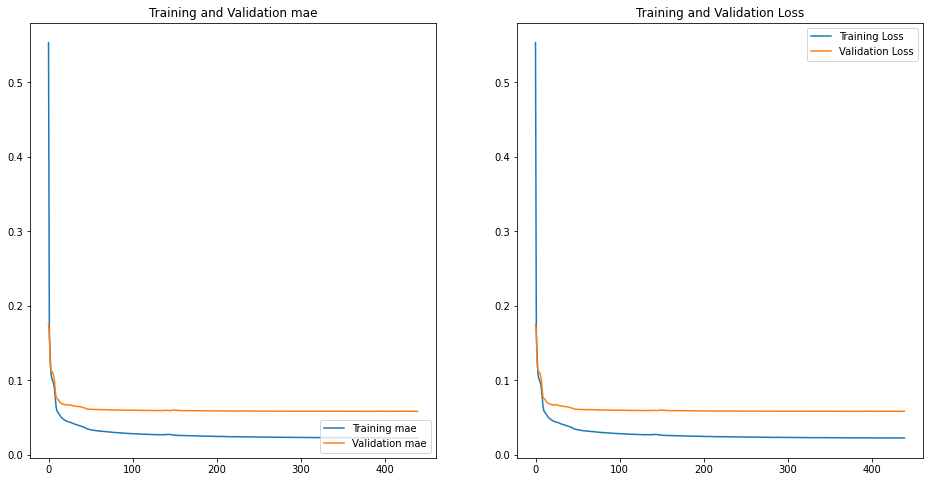

In [12]:
def show_accuracy(history):
    acc = history.history['mae']
    val_acc = history.history['val_mae']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(range(len(acc)), acc, label='Training mae')
    plt.plot(range(len(val_acc)), val_acc, label='Validation mae')
    plt.legend(loc='lower right')
    plt.title('Training and Validation mae')

    plt.subplot(1, 2, 2)
    plt.plot(range(len(loss)), loss, label='Training Loss')
    plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

show_accuracy(training_history)

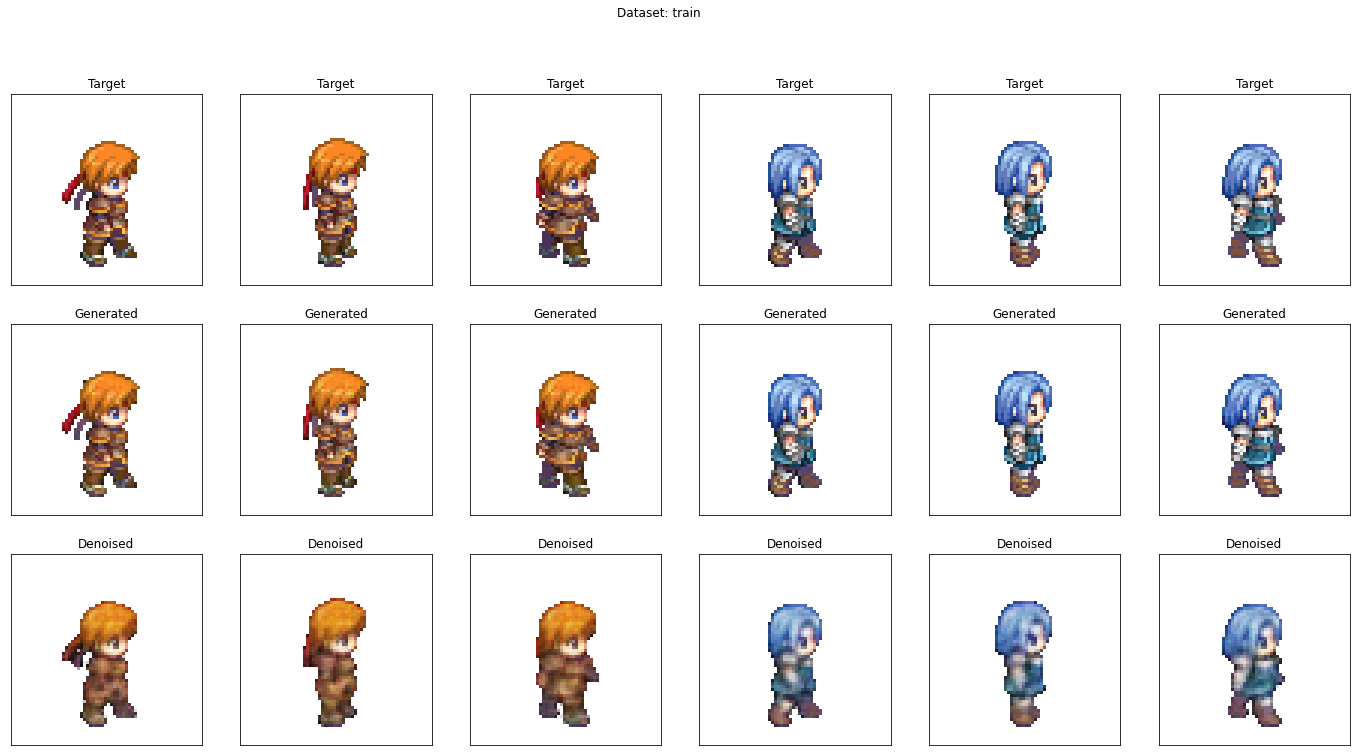

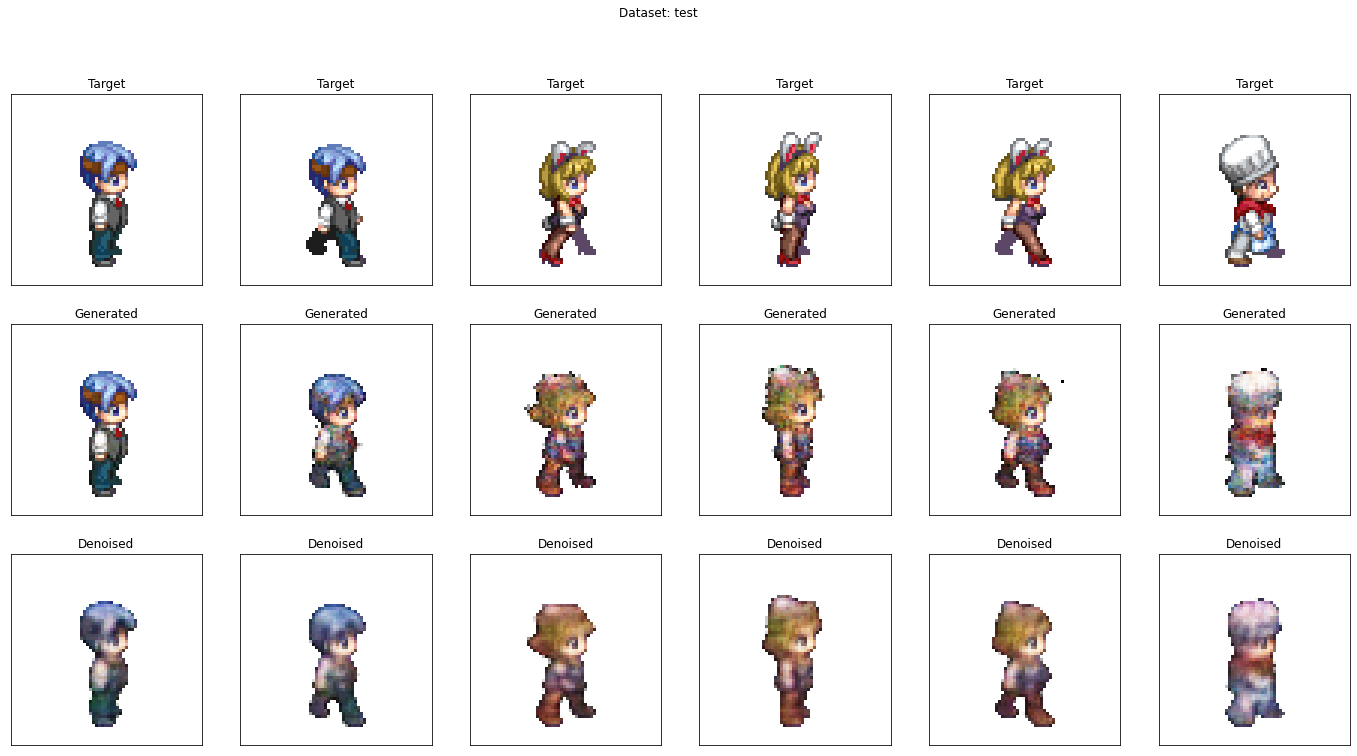

In [13]:
def show_images(model, ds, ds_name):
    num_images = 6
    plt.figure(figsize=(24, 12))
    plt.suptitle(f"Dataset: {ds_name}")
    for i, (noisy_image, target_image) in ds.unbatch().take(num_images).batch(1).enumerate():
        i = i.numpy()
        encoded_image = model.encoder(noisy_image)
        decoded_image = model.decoder(encoded_image)
        decoded_image = tf.clip_by_value(decoded_image, -1., 1.)

        # display original, original+noise, then reconstructed
        images = [target_image, noisy_image, decoded_image]
        titles = ["Target", "Generated", "Denoised"]
        for j, (image, title) in enumerate(zip(images, titles)):
            ax = plt.subplot(3, num_images, num_images*j + i+1)
            plt.title(title)
            plt.imshow(tf.squeeze(image) * 0.5 + 0.5, interpolation="nearest")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    # plt.show()

show_images(denoiser, train_ds, "train")
show_images(denoiser, test_ds, "test")